# INF554 Team ==Baseline== Node2Vec Feature Extraction and Model Training
### Francisco, Alex and Aksel

## 1.1 Importing Libraries and Loading the Datasets

In [75]:
import random
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
import seaborn as sns
import os
import networkx as nx
import pdb
import pickle
from collections import Counter
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction import text as fe
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import datetime
import time
import keras
import lightgbm
import spacy
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
import nltk
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin

Note: running all of the following feature extraction cells will take a long time. However, after running for the first time the computationally intensive part of the feature is pickled and so can be easily calculated in subsequent runs. Many of the cells (especially in the feature extraction section) will use this technique.

In [76]:
with open(r"training.txt", "r") as f:
    reader = csv.reader(f)
    training  = list(reader)
# in order of training examples
training = [element[0].split(" ") for element in training]
training = pd.DataFrame(training, columns=['Node1', 'Node2', 'Link'])
print("Training examples shape: {}".format(training.shape))

with open(r"testing.txt", "r") as f:
    reader = csv.reader(f)
    testing  = list(reader)
# in order of testing examples
testing = [element[0].split(" ") for element in testing]
testing = pd.DataFrame(testing, columns=['Node1', 'Node2'])
print("Testing examples shape: {}".format(testing.shape))

Training examples shape: (453797, 3)
Testing examples shape: (113450, 2)


In [77]:
# directory to store extracted features
if not os.path.exists(r'pickles'):
    os.mkdir(r'pickles')

In [78]:
'''
load the corpus one file at a time, remove spaces and convert to lower case
'''
NODE_INFO_DIRECTORY = r"node_information/text/"

corpus_path = r"pickles/simple_corpus.PICKLE" 
ids_path = r"pickles/ids.PICKLE"
if os.path.exists(corpus_path):
    with open(corpus_path, 'rb') as f:
        corpus = pickle.load(f)
    f.close()
    with open(ids_path, 'rb') as f:
        ids = pickle.load(f)
    f.close()
else:
    corpus = []
    ids = []
    for filename in tqdm(os.listdir(NODE_INFO_DIRECTORY), position=0, leave=True):
        with open(NODE_INFO_DIRECTORY + filename, 'r', encoding='UTF-8', errors='ignore') as f:
            doc_string = []
            for line in f:
                [doc_string.append(token.strip()) for token in line.lower().strip().split(" ") if token != ""]
            corpus.append(' '.join(doc_string))
            ids.append(filename[:-4])
    with open(corpus_path, '+wb') as f:
        pickle.dump(corpus, f)
    f.close()
    with open(ids_path, '+wb') as f:
        pickle.dump(ids, f)
    f.close() 

In [79]:
# stemmed corpus is created by Preprocessing.ipynb file
stemmed_corpus_path = r"pickles/stemmed_corpus.PICKLE" 
if os.path.exists(stemmed_corpus_path):
    with open(stemmed_corpus_path, 'rb') as f:
        stemmed_corpus = pickle.load(f)
    f.close()
else:
    print('Stemmed corpus unavailable, please run the Preprocessing.ipynb file')

# in order of alphabetical text information i.e. 0, 1, 10, 100
node_info = pd.DataFrame({'id': ids, 'corpus': corpus, 'stemmed': stemmed_corpus})
node_info_id = node_info.set_index(['id'])
print("Training node info shape: {}".format(node_info.shape))

Training node info shape: (33226, 3)


In [80]:
# make graph/ feature extraction split (saved for reproducable results)
train_graph_split_path = 'pickles/train_graph_split_5.PICKLE'

if os.path.exists(train_graph_split_path):
    with open(train_graph_split_path, 'rb') as f:
        keep_indices = pickle.load(f)
    f.close()
else:
    keep_indices = random.sample(range(len(training)), k=int(len(training) * 0.05))
    with open(train_graph_split_path, '+wb') as f:
        pickle.dump(keep_indices, f)
    f.close()

data_train_val = training.iloc[keep_indices]
data_train = training.loc[~training.index.isin(keep_indices)]

In [81]:
linked_nodes = data_train.loc[data_train['Link']=='1']
linked_nodes = linked_nodes[['Node1', 'Node2']]
linked_nodes.to_csv('linked_nodes.txt', sep=' ', index=False, header=False)
G=nx.read_edgelist('linked_nodes.txt', create_using=nx.Graph(), nodetype = str)
graph=G

## 1.2 Load Already Extracted Node2Vec Features

In [82]:
# run INF554_Node2Vec.ipynb before running this file otherwise the files below will not be available
feature_vector_path = r"pickles/perf_val_data_node2vec_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        df_train = pickle.load(f)
    f.close()

feature_vector_path = r"pickles/perf_test_data_node2vec_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        df_test = pickle.load(f)
    f.close()

In [83]:
# run INF554_Simple.ipynb before running this file otherwise the files below will not be available
feature_vector_path = r"pickles/perf_val_data_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_val_data = pickle.load(f)
    f.close()

feature_vector_path = r"pickles/perf_test_data_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_test_data = pickle.load(f)
    f.close()

## 2.1 Boosting Node2Vec with Simple Features

In [84]:
extended_model_train = pd.concat([perf_val_data, df_train], axis =1)
extended_model_test = pd.concat([perf_test_data, df_test], axis =1)
extended_model_train

,Node1,Node2,Link,original_index,tfidf_similarity,languages_similarity,joint_length,file_distance,common_neighbors,jaccard_coefficient,...,54,55,56,57,58,59,60,61,62,63
0,15766,25303,0,74300,0.023037,0.988888,14323303,9537,0,0.000000,...,1.013159,-1.352759,0.079498,-0.285837,0.034916,0.128856,1.164120,1.477746,-2.294661,-0.959510
1,1242,16346,1,199347,0.112086,0.989672,653097951,15104,0,0.000000,...,-1.215659,4.268219,4.522655,-3.329852,2.090041,-4.684298,-1.913933,-1.695607,-6.919380,5.877547
2,19458,2686,1,23408,0.632883,0.993145,4803096464,16772,2,0.037736,...,-1.956275,-3.803782,0.974259,3.482403,-1.434953,0.492009,-3.517188,-0.247641,-1.390207,1.415396
3,9450,9445,1,291622,0.292075,0.956078,54226056,5,32,0.653061,...,-2.787038,0.814969,-0.491028,4.775116,-1.514552,-1.526252,-0.290796,0.077616,-1.414410,2.253868
4,649,2192,1,218722,0.195188,0.985659,122628987,1543,9,0.041475,...,1.692338,-1.453239,2.619360,-4.745262,3.069906,-0.515665,-4.346972,8.093157,1.984563,-0.583196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22684,785,401,1,299246,0.038760,0.987210,6618625699,384,2,0.005450,...,-0.887301,-5.402542,3.736914,-4.449623,-0.439290,-2.144789,-2.975514,2.957502,2.767964,-2.703963
22685,26865,15865,1,436629,0.001919,0.347923,2167836,11000,0,0.000000,...,3.463235,-1.732057,1.121991,1.005454,1.929062,-4.464622,-0.529654,-4.737908,-1.902947,-0.924929
22686,19714,14354,0,380087,0.000847,0.560130,12368215,5360,0,0.000000,...,-1.535884,-0.923492,-1.707197,2.051680,-1.353925,0.780039,1.173839,1.258558,2.113299,0.756226
22687,6883,10255,0,13628,0.009943,0.994455,229149154,3372,0,0.000000,...,-1.317717,2.878164,-3.216761,-0.500635,0.227903,1.825828,1.702644,2.633389,1.121629,1.628299


In [175]:
from sklearn.preprocessing import StandardScaler

d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in extended_model_train.columns if i not in d_columns]
X = extended_model_train[cols]
y = list(map(lambda i: int(i), data_train_val['Link']))

scaler = StandardScaler()
normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(normalized, y, test_size=0.15, random_state=1)

## 3.2 Feature Importance and Selection

In [36]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9508196721311475


In [22]:
# use the LGMB method 'feature_importances_' to extract features which are most relevant
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model_lgbm.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

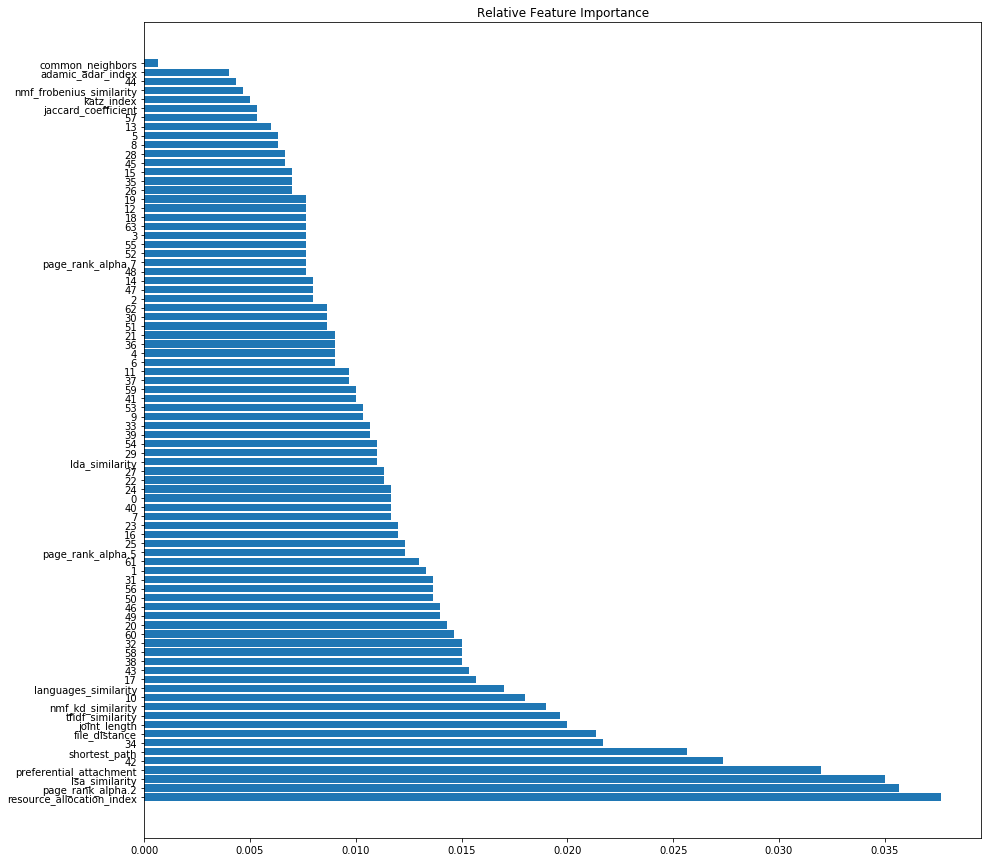

In [27]:
importance = np.array(features.values.reshape(-1))
importance = list(importance/importance.sum(axis=0,keepdims=1))
bars = list(features.index.values)
y_pos = np.arange(len(bars))

fig, ax = plt.subplots(figsize=(15,15))

# Create horizontal bars, and place names of features on the vertical axis
plt.barh(y_pos, importance)
plt.yticks(y_pos, bars)
plt.title("Relative Feature Importance")
plt.show()

In [28]:
# using the RFE to select features by recursively considering smaller and smaller sets of features.
from sklearn.feature_selection import RFE
selector = RFE(lgbm, 20)
selector = selector.fit(normalized, y)
print(selector.support_)
print(selector.ranking_)

[False False  True  True False False False False  True  True False False
 False False  True False  True  True  True False False False False False
 False False False False  True False False False False False  True  True
 False False  True False False False  True False False  True False  True
 False False  True False  True False False False False False False False
  True False False False False False False False False False False  True
 False False False False False False  True False False False]
[23  9  1  1 63 58  2 57  1  1 61 17 60 14  1 54  1  1  1 24 47 30 26 46
 36 19 50 15  1 12 31 51 29 49  1  1 40 16  1 38  5 10  1 32 43  1 44  1
 34 37  1 28  1 41 13 20  7 21 35 27  1  4 55 56 18 39 52 11 22 33 62  1
 25 59  3 45  8 53  1  6 42 48]


In [60]:
selected_columns = X.columns[selector.support_]
selected_columns

Index([             'joint_length',             'file_distance',
       'resource_allocation_index',   'preferential_attachment',
               'page_rank_alpha.2',         'nmf_kd_similarity',
                  'lsa_similarity',                           0,
                                10,                          16,
                                17,                          20,
                                24,                          27,
                                29,                          32,
                                34,                          42,
                                53,                          60],
      dtype='object')

In [30]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train[:, selector.support_], y_train)
predictions = model_lgbm.predict(X_test[:, selector.support_])
print(f1_score(y_test, np.round(predictions)))

0.9465301478953356


## 3.3 Hyperparameter Tuning

In [171]:
# create a suitable F1 score function for hyperopt to use
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    pred_label = np.round(preds)
    f_score = f1_score(pred_label, labels)
    return 'f1_score', f_score, True

def hyperopt(X, y, params):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)
    train_data = lightgbm.Dataset(X_train, label=y_train)
    valid_data = lightgbm.Dataset(X_val, label=y_val)

    # limitting the max depth and feature fraction corresponds to preventing over fitting of the model. 
    # Regularization parameters alpha and lambda also prevent over fitting
    space = {
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
        "max_depth": hp.choice("max_depth", [3, 4, 5, 6, 7]),
        "num_leaves": hp.choice("num_leaves", np.linspace(10, 200, 50, dtype=int)),
        "feature_fraction": hp.quniform("feature_fraction", 0.6, 1.0, 0.1),
        "reg_alpha": hp.uniform("reg_alpha", 0, 2),
        "reg_lambda": hp.uniform("reg_lambda", 0, 2),
        "min_child_weight": hp.uniform('min_child_weight', 0.5, 10),
    }

    def objective(hyperparams):
        model = lightgbm.train({**params, **hyperparams}, train_data, 300, 
                               valid_data, early_stopping_rounds=30, verbose_eval=0, feval = evalerror)

        score = model.best_score["valid_0"]['f1_score']
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, trials=trials,
                algo=tpe.suggest, max_evals=50, verbose=1,
                rstate=np.random.RandomState(1))

    hyperparams = space_eval(space, best)

    print(f"auc = {-trials.best_trial['result']['loss']:0.4f} {hyperparams}")

    return hyperparams


In [172]:
# run the hyperparameter search using a random grid search defined above
params = {
    "objective": "binary",
    "metric": 'f1_score',
    "verbosity": -1,
    "seed": 1,
    "num_threads": 4
}
hyperparams = hyperopt(X, y, params)

100%|██████████████████████████████████████████████████| 50/50 [03:39<00:00,  4.40s/it, best loss: -0.9491003290625218]
auc = 0.9491 {'feature_fraction': 1.0, 'learning_rate': 0.14204952501005894, 'max_depth': 5, 'min_child_weight': 5.5702484952829066, 'num_leaves': 149, 'reg_alpha': 1.5244467991842399, 'reg_lambda': 0.9052979923420648}


## 4.1 Kaggle Prediction using Optimal Hyperparameters

In [194]:
# use the hyperparameters found above to train the final model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

train_data = lightgbm.Dataset(X_train, label=y_train)
valid_data = lightgbm.Dataset(X_test, label=y_test)

model = lightgbm.train({**params, **hyperparams}, train_data, 500,
                       valid_data, early_stopping_rounds=30, verbose_eval=100, feval = evalerror)

predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, np.round(predictions)))

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's f1_score: 0.936849
0.9420457169244979


In [81]:
d_columns = ['original_index', 'Node1', 'Node2']
cols = [i for i in extended_model_test.columns if i not in d_columns]

model = lightgbm.LGBMClassifier(**hyperparams)
model = model.fit(X, y, eval_metric = evalerror)
predictions = model.predict(extended_model_test[cols])

In [28]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("distance_prediction2.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## 4.2 Kaggle Prediction Naive

In [52]:
d_columns = ['original_index', 'Node1', 'Node2']
cols = [i for i in extended_model_test.columns if i not in d_columns]

model = lightgbm.LGBMClassifier()
model = model.fit(X, y)
normalized_test = scaler.fit_transform(extended_model_test[cols])
predictions = model.predict(normalized_test)

In [129]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("Boosted_prediction_reduced_features.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## 4.3 Kaggle Prediction Reduced Naive

In [72]:
d_columns = ['original_index', 'Node1', 'Node2']
cols = [i for i in extended_model_test.columns if i in selected_columns]

model = lightgbm.LGBMClassifier()
model = model.fit(normalized[:, selector.support_], y)
normalized_test = scaler.fit_transform(extended_model_test[cols])
predictions = model.predict(normalized_test)

In [73]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("Boosted_prediction_reduced_features.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## 5.1 Simple Model Predictions

In [195]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in perf_val_data.columns if i not in d_columns]
X = perf_val_data[cols]
y = list(map(lambda i: int(i), data_train_val['Link']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9402917046490429


In [92]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
simple_predictions = model_lgbm.predict(perf_test_data[cols])

## 5.2 Node2Vec Model Predictions

In [158]:
X = df_train
y = list(map(lambda i: int(i), data_train_val['Link']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9274774774774774


In [94]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
node2vec_predictions = model_lgbm.predict(df_test)

## 5.3 Augmented Node2Vec Model Predictions

In [196]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in extended_model_train.columns if i not in d_columns]
X = extended_model_train[cols]
y = list(map(lambda i: int(i), data_train_val['Link']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier(**hyperparams)
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9477049554692853


In [197]:
lgbm = lightgbm.LGBMClassifier(**hyperparams)
model_lgbm = lgbm.fit(X, y)
extended_features_predictions = model_lgbm.predict(extended_model_test[cols])

## Creating Simple Ensemble

In [145]:
predictions = np.array([int(i) for i in ((simple_predictions + node2vec_predictions + extended_features_predictions) >= 2)])
predictions

array([1, 1, 0, ..., 0, 1, 1])

In [124]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(extended_features_predictions_RF)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("RF_hyperopt_pred.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## Keras

In [164]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

scaler = StandardScaler()
normalized = scaler.fit_transform(X)

from keras import backend as K
from keras import callbacks
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model():
    model = Sequential()
    model.add(Dense(50, input_dim=normalized.shape[1], activation='relu'))
    BatchNormalization()
    Dropout(rate=0.5)
    model.add(Dense(50, activation='relu'))
    Dropout(rate=0.5)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m])
    return(model)

multi_rnn = create_model()

In [165]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = multi_rnn.fit(normalized, y, epochs = 100, batch_size = 500, verbose = 2, validation_split=0.25, callbacks=[es])

Train on 17016 samples, validate on 5673 samples
Epoch 1/100
 - 2s - loss: 0.5562 - acc: 0.6758 - f1_m: 0.7589 - val_loss: 0.4260 - val_acc: 0.8232 - val_f1_m: 0.8684
Epoch 2/100
 - 0s - loss: 0.3703 - acc: 0.8531 - f1_m: 0.8858 - val_loss: 0.3099 - val_acc: 0.8794 - val_f1_m: 0.9058
Epoch 3/100
 - 0s - loss: 0.2882 - acc: 0.8867 - f1_m: 0.9098 - val_loss: 0.2636 - val_acc: 0.8972 - val_f1_m: 0.9191
Epoch 4/100
 - 0s - loss: 0.2494 - acc: 0.9020 - f1_m: 0.9216 - val_loss: 0.2408 - val_acc: 0.9032 - val_f1_m: 0.9234
Epoch 5/100
 - 0s - loss: 0.2267 - acc: 0.9117 - f1_m: 0.9294 - val_loss: 0.2265 - val_acc: 0.9094 - val_f1_m: 0.9281
Epoch 6/100
 - 0s - loss: 0.2107 - acc: 0.9180 - f1_m: 0.9344 - val_loss: 0.2169 - val_acc: 0.9119 - val_f1_m: 0.9304
Epoch 7/100
 - 0s - loss: 0.1983 - acc: 0.9227 - f1_m: 0.9383 - val_loss: 0.2108 - val_acc: 0.9136 - val_f1_m: 0.9318
Epoch 8/100
 - 0s - loss: 0.1891 - acc: 0.9274 - f1_m: 0.9419 - val_loss: 0.2043 - val_acc: 0.9182 - val_f1_m: 0.9349
Epoch 9

In [166]:
normalized_kaggle = scaler.fit_transform(extended_model_test[cols])
keras_predictions = list(np.round(multi_rnn.predict(normalized_kaggle)).reshape(-1).astype(int))

## 5.3 Augmented Node2Vec Model Predictions RF

In [232]:
def hyperopt_RF(X, y, params):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)
    # limitting the max depth and feature fraction corresponds to preventing over fitting of the model. 
    # Regularization parameters alpha and lambda also prevent over fitting
    space = {
        
        #'bootstrap': hp.choice('bootstrap', [True, False]),
        'max_depth': hp.quniform("max_depth", 2, 20, 2),
        'max_features': hp.choice('max_features', ['auto', 'sqrt']),
        'min_samples_leaf': hp.choice('min_samples_leaf', np.linspace(1, 5, 1, dtype=int)),
        'min_samples_split': hp.choice('min_samples_split', np.linspace(2, 10, 2, dtype=int)),
        'n_estimators': hp.choice('n_estimators', np.linspace(100, 500, 100, dtype=int))
    }

    def objective(hyperparams):
        model = RandomForestClassifier(**hyperparams)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = f1_score(y_test, predictions)
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, trials=trials,
                algo=tpe.suggest, max_evals=10, verbose=1,
                rstate=np.random.RandomState(1))

    hyperparams = space_eval(space, best)

    print(f"auc = {-trials.best_trial['result']['loss']:0.4f} {hyperparams}")

    return hyperparams


In [233]:
# run the hyperparameter search using a random grid search defined above
params = {
    "objective": "binary",
    "metric": 'f1_score',
    "verbosity": -1,
    "seed": 1,
    "num_threads": 4
}
hyperparams = hyperopt_RF(X, y, params)

100%|██████████████████████████████████████████████████| 10/10 [03:36<00:00, 21.68s/it, best loss: -0.9691004806591896]
auc = 0.9691 {'bootstrap': False, 'max_depth': 16.0, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 411}


In [234]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in extended_model_train.columns if i not in d_columns]
X = extended_model_train[cols]
y = list(map(lambda i: int(i), data_train_val['Link']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
RF = RandomForestClassifier(**hyperparams)
model_RF = RF.fit(X_train, y_train)
predictions = model_RF.predict(X_test)
print(f1_score(y_test, predictions))

0.9422202001819836


In [236]:
RF = RandomForestClassifier(**hyperparams)
model_RF = RF.fit(X, y)
extended_features_predictions_RF = model_RF.predict(extended_model_test[cols])

## Creating Complex Ensemble

In [146]:
sum(predictions==predictions2)/len(predictions)

0.9812692816218599

In [144]:
predictions2 = np.array([int(i) for i in ((keras_predictions + extended_features_predictions_RF + extended_features_predictions) >= 2)])
predictions2

array([1, 1, 0, ..., 0, 1, 1])

In [147]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions2)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("Complex_ensemble_Keras_RF_pred.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## Creating Complex Ensemble 2

In [240]:
sum(predictions2==predictions3)/len(predictions2)

0.9804847950639048

In [239]:
predictions3 = np.array([int(i) for i in ((keras_predictions + extended_features_predictions_RF + extended_features_predictions) >= 2)])
predictions3

array([1, 1, 0, ..., 0, 1, 1])

In [242]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions3)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("Complex_ensemble_Keras_RF_hyperopt_pred.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)